# Курсовой проект по стоимости квартиры

> Course project on the cost of an apartment

- toc: true
- branch: master
- badges: true
- comments: true
- author: Zmey56
- categories: [course project, machine learning, classification, geekbrain]

Текста будет немного, в основном решениие. Несмотря на негативный кай я считаю отзыв преподавателя - среди 60 однокурсников занял 2 место, а на kaggle 67 место из 487. Так что уважаемый преподаватель наверное что-то я улучшил удалось, а вы просто видимо загружены большим количеством контрольных и не смогли подробно разобрать. Но цитату Вашу привожу без изменений - может кому понадобиться:

> Вы добавили графики, не стали отбирать лучшие признаки и проверяли точность модели только на кагле. ник AlexTUT56? ваших новых признаков нет, схемы для валидации модели нет.
блокнот, что мы разбирали на вебинаре, был дан как основа. либо вы предлагаете свое оригинальное решение, либо улучшаете существующее. улучшить не удалось.

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.5)  
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 50)

In [3]:
def adjustedR2(r2,n,k):
    return r2-(k-1)/(n-k)*(1-r2)

In [4]:
TRAIN_DATASET_PATH = 'project/train.csv'
TEST_DATASET_PATH = 'project/test.csv'

# 1. Загружаю данные

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, index_col='Id')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,B,B,33,7976,5,NaN,0,11,B,"184,966.93"
15053,41,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,B,B,46,10309,1,240.00,1,16,B,"300,009.45"
4765,53,2.00,44.95,29.20,0.00,8,12.00,1968,0.05,B,B,34,7759,0,229.00,1,3,B,"220,925.91"
5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,B,B,23,5735,3,"1,084.00",0,5,B,"175,616.23"
10783,99,1.00,39.65,23.78,7.00,11,12.00,1976,0.01,B,B,35,5776,1,"2,078.00",2,4,B,"150,226.53"


In [6]:
test_df = pd.read_csv(TEST_DATASET_PATH, index_col='Id')
test_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
725,58,2.00,49.88,33.43,6.00,6,14.00,1972,0.31,B,B,11,2748,1,NaN,0,0,B
15856,74,2.00,69.26,NaN,1.00,6,1.00,1977,0.08,B,B,6,1437,3,NaN,0,2,B
5480,190,1.00,13.60,15.95,12.00,2,5.00,1909,0.00,B,B,30,7538,87,"4,702.00",5,5,B
15664,47,2.00,73.05,51.94,9.00,22,22.00,2007,0.10,B,B,23,4583,3,NaN,3,3,B
14275,27,1.00,47.53,43.39,1.00,17,17.00,2017,0.07,B,B,2,629,1,NaN,0,0,A


In [7]:
train_df.shape, test_df.shape

((10000, 19), (5000, 18))

# 2. Визуальный анализ данных

Воспользуюсь вариантом предложенным на уроке и собственными мыслями. Первым шагом познакомимся с данными. Построим их гистограммы, а тех, которых не много - box-plot.

In [8]:
train_df.columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2',
       'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

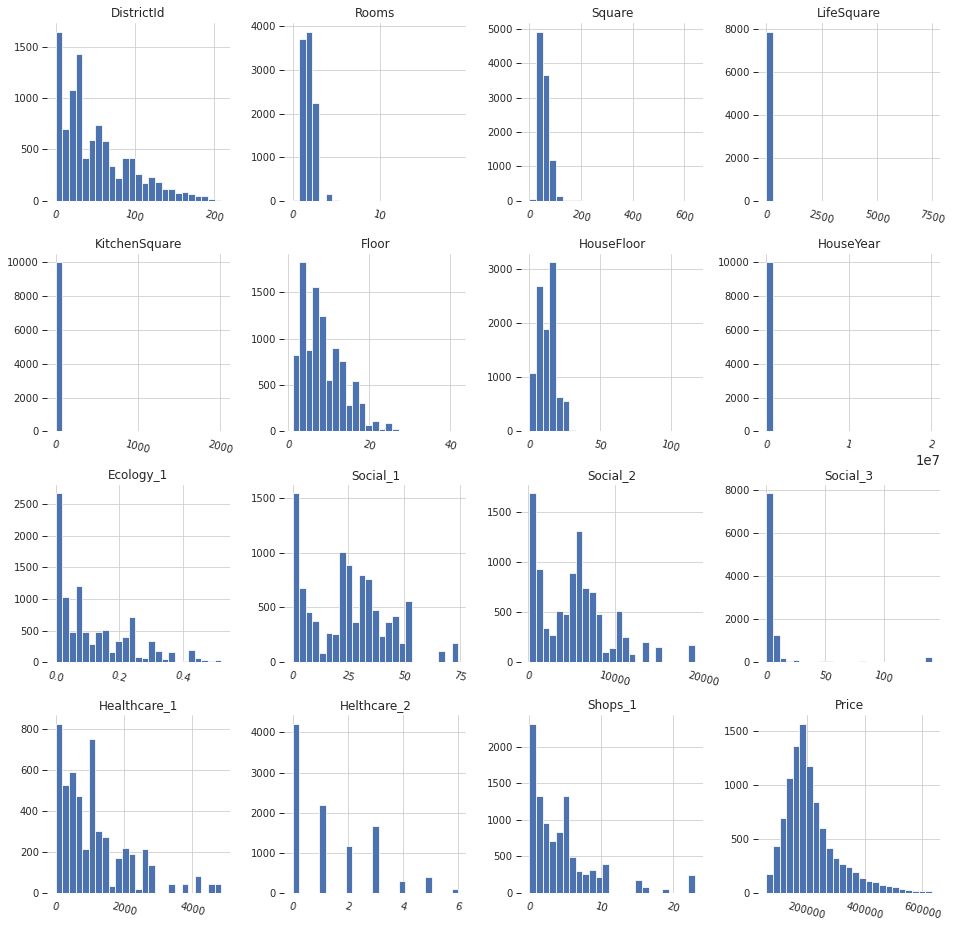

In [9]:
df1=train_df[['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2',
       'Shops_1', 'Shops_2', 'Price']]
h = df1.hist(bins=25,figsize=(16,16),xlabelsize='10',ylabelsize='10',xrot=-15)
sns.despine(left=True, bottom=True)
[x.title.set_size(12) for x in h.ravel()];
[x.yaxis.tick_left() for x in h.ravel()];

In [10]:
sns.set(style="whitegrid", font_scale=1)

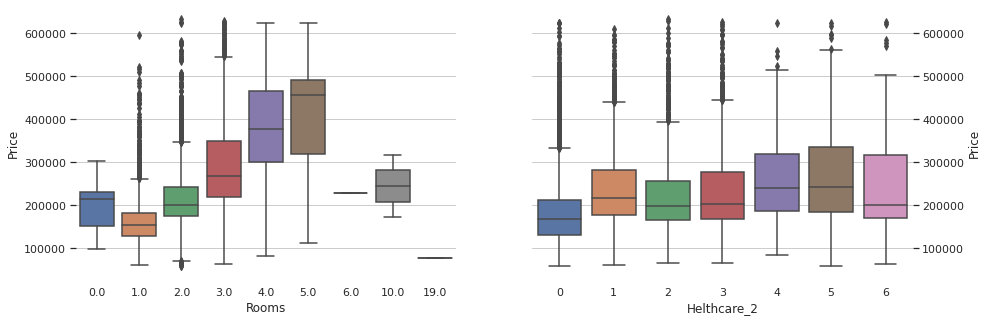

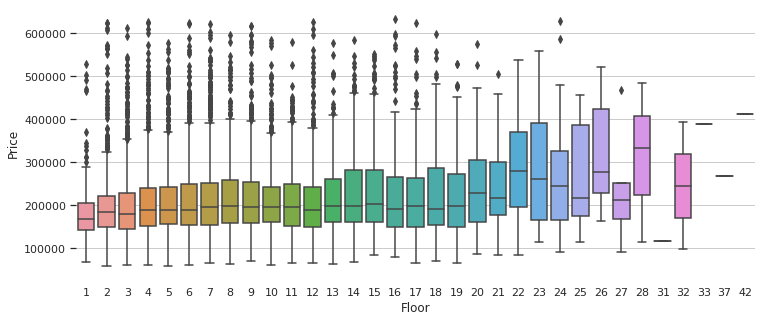

In [11]:
f, axes = plt.subplots(1, 2,figsize=(15,5))
sns.boxplot(x=train_df['Rooms'],y=train_df['Price'], ax=axes[0])
sns.boxplot(x=train_df['Helthcare_2'],y=train_df['Price'], ax=axes[1])
sns.despine(left=True, bottom=True)
axes[0].set(xlabel='Rooms', ylabel='Price')
axes[0].yaxis.tick_left()
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].set(xlabel='Helthcare_2', ylabel='Price')

f, axe = plt.subplots(1, 1,figsize=(12.18,5))
sns.despine(left=True, bottom=True)
sns.boxplot(x=train_df['Floor'],y=train_df['Price'], ax=axe)
axe.yaxis.tick_left()
axe.set(xlabel='Floor', ylabel='Price');

Можно конечно еще долго играться с графиками, но визуально выявить влияние вряд-ли удасться. Посмотрю на корреляцию между данными.

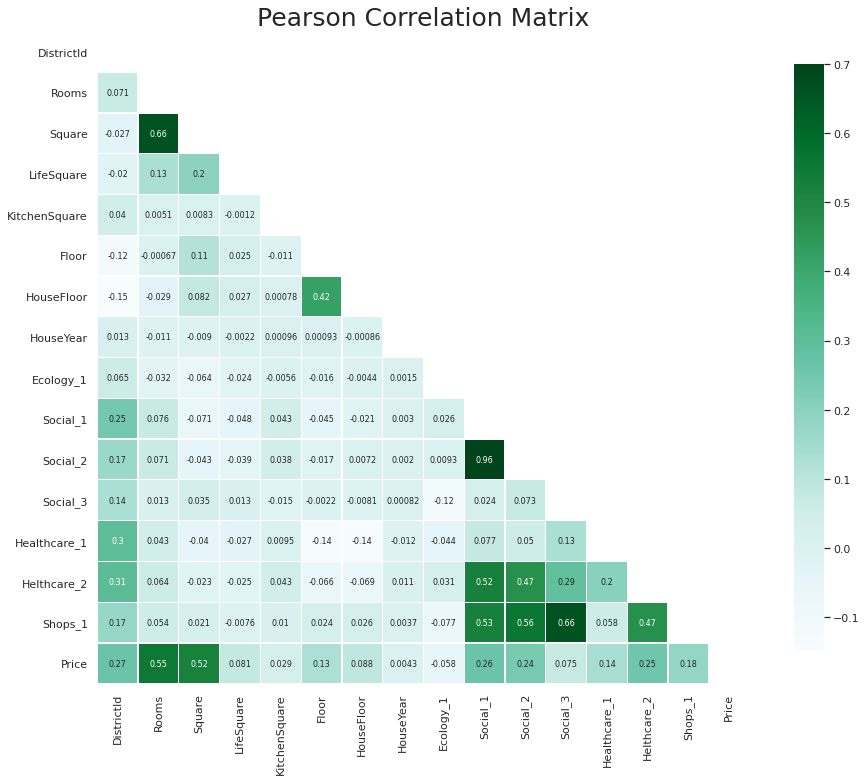

In [12]:
features = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2',
       'Shops_1', 'Shops_2', 'Price']

mask = np.zeros_like(train_df[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)


sns.heatmap(train_df[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

# 3. Подготовка данных

Для подготовки воспользуюсь примером из урока

### 3.1 Приведение типов

In [13]:
train_df.dtypes

DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [14]:
train_df['DistrictId'] = train_df['DistrictId'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

In [15]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,"10,000.00","10,000.00","7,887.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","5,202.00","10,000.00","10,000.00","10,000.00"
mean,1.89,56.32,37.20,6.27,8.53,12.61,"3,990.17",0.12,24.69,"5,352.16",8.04,"1,142.90",1.32,4.23,"214,138.86"
std,0.84,21.06,86.24,28.56,5.24,6.78,"200,500.26",0.12,17.53,"4,006.80",23.83,"1,021.52",1.49,4.81,"92,872.29"
min,0.00,1.14,0.37,0.00,1.00,0.00,"1,910.00",0.00,0.00,168.00,0.00,0.00,0.00,0.00,"59,174.78"
25%,1.00,41.77,22.77,1.00,4.00,9.00,"1,974.00",0.02,6.00,"1,564.00",0.00,350.00,0.00,1.00,"153,872.63"
50%,2.00,52.51,32.78,6.00,7.00,13.00,"1,977.00",0.08,25.00,"5,285.00",2.00,900.00,1.00,3.00,"192,269.64"
75%,2.00,65.90,45.13,9.00,12.00,17.00,"2,001.00",0.20,36.00,"7,227.00",5.00,"1,548.00",2.00,6.00,"249,135.46"
max,19.00,641.07,"7,480.59","2,014.00",42.00,117.00,"20,052,011.00",0.52,74.00,"19,083.00",141.00,"4,849.00",6.00,23.00,"633,233.47"


In [16]:
feature_num_names = train_df.drop('Price', axis=1).select_dtypes(include=['float64', 'int64']).\
        columns.tolist()
feature_num_names

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1']

In [17]:
feature_cat_names = train_df.select_dtypes(include='object').columns.tolist()
feature_cat_names

['DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [18]:
feature_bin_names = ['Ecology_2', 'Ecology_3', 'Shops_2']

train_df[feature_bin_names] = train_df[feature_bin_names].replace({'A':0, 'B':1})
test_df[feature_bin_names] = test_df[feature_bin_names].replace({'A':0, 'B':1})

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  object 
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  int64  
 10  Ecology_3      10000 non-null  int64  
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  int64  
 18  Pri

### 3.2. Пропущенные значения

In [19]:
train_df.isna().sum()[train_df.isna().sum() != 0]

LifeSquare      2113
Healthcare_1    4798
dtype: int64

In [20]:
train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare'] = \
    train_df['Square'] - train_df['KitchenSquare']
test_df.loc[test_df['LifeSquare'].isna(), 'LifeSquare'] = \
    test_df['Square'] - test_df['KitchenSquare']

In [21]:
pd.concat([train_df.groupby('DistrictId')['Healthcare_1'].apply(lambda x: np.nanmean(x)),
          train_df.groupby('DistrictId')['Healthcare_1'].apply(lambda x: np.nanstd(x)),
          train_df.groupby('DistrictId')['Healthcare_1'].count(),
          train_df.groupby('DistrictId')['Healthcare_1'].apply(lambda x: x.isna().sum())
          ], 
          axis=1, keys=['mean', 'std', 'count', 'nans']).sort_values(by='nans', ascending=False).head(10)

,mean,std,count,nans
DistrictId,,,,
27,NaN,NaN,0,851
1,228.77,17.97,57,595
23,0.00,0.00,1,564
62,"2,300.00",0.00,9,238
45,NaN,NaN,0,116
34,NaN,NaN,0,111
61,80.00,0.00,8,110
13,"1,406.00",0.00,4,93
9,30.00,0.00,202,92


In [22]:
pd.concat([train_df.groupby('Helthcare_2')['Healthcare_1'].apply(lambda x: np.nanmean(x)),
          train_df.groupby('Helthcare_2')['Healthcare_1'].apply(lambda x: np.nanstd(x)),
          train_df.groupby('Helthcare_2')['Healthcare_1'].count(),
          train_df.groupby('Helthcare_2')['Healthcare_1'].apply(lambda x: x.isna().sum())
          ], 
          axis=1, keys=['mean', 'std', 'count', 'nans']).sort_values(by='nans', ascending=False)

,mean,std,count,nans
Helthcare_2,,,,
0,"1,007.78",913.61,1275,2939
1,811.36,696.54,925,1258
3,"1,363.38","1,005.68",1347,323
5,"1,824.09","1,574.23",212,176
2,"1,010.71","1,045.44",1056,102
4,"1,929.23","1,121.87",288,0
6,645.00,0.00,99,0


In [23]:
pd.concat([test_df.groupby('Helthcare_2')['Healthcare_1'].apply(lambda x: np.nanmean(x)),
          test_df.groupby('Helthcare_2')['Healthcare_1'].apply(lambda x: np.nanstd(x)),
          test_df.groupby('Helthcare_2')['Healthcare_1'].count(),
          test_df.groupby('Helthcare_2')['Healthcare_1'].apply(lambda x: x.isna().sum())
          ], 
          axis=1, keys=['mean', 'std', 'count', 'nans']).sort_values(by='nans', ascending=False)

,mean,std,count,nans
Helthcare_2,,,,
0,976.07,905.42,667,1429
1,836.12,738.36,442,654
3,"1,353.30","1,064.11",700,155
5,"1,606.40","1,528.20",97,89
2,"1,095.59","1,135.98",520,50
4,"1,829.66","1,086.82",158,0
6,645.00,0.00,39,0


In [24]:
train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] =\
    train_df.groupby(['Helthcare_2'])['Healthcare_1'].transform(lambda x: x.mean())

In [25]:
test_df.loc[test_df['Healthcare_1'].isna(), 'Healthcare_1'] =\
    train_df.groupby(['Helthcare_2'])['Healthcare_1'].transform(lambda x: x.mean())

In [26]:
test_df['Healthcare_1'] = test_df['Healthcare_1'].fillna(test_df.groupby('Helthcare_2')['Healthcare_1'].transform('mean'))

### 3.3. Обработка аномальных значений

In [27]:
train_df['Rooms'].value_counts()

2.00     3880
1.00     3705
3.00     2235
4.00      150
5.00       18
0.00        8
10.00       2
6.00        1
19.00       1
Name: Rooms, dtype: int64

In [28]:
train_df.loc[(train_df['Rooms'] > 5)|(train_df['Rooms'] == 0), 'Rooms'] = train_df['Rooms'].mode()[0]
test_df.loc[(test_df['Rooms'] > 5)|(test_df['Rooms'] == 0), 'Rooms'] = train_df['Rooms'].mode()[0] # !!

In [29]:
train_df.loc[(train_df['KitchenSquare'] > 150) | \
             (train_df['KitchenSquare'] > train_df['Square']), :]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14656,62,1.00,47.10,46.45,"2,014.00",4,1.00,2014,0.07,1,1,2,629,1,"1,007.78",0,0,0,"108,337.48"
13703,42,1.00,38.07,19.72,73.00,9,10.00,2006,0.16,1,1,21,5731,0,811.36,1,0,1,"160,488.03"
6569,27,1.00,38.22,18.72,84.00,4,17.00,2018,0.01,1,1,4,915,0,"1,007.78",0,0,1,"99,079.96"
14679,81,1.00,32.28,19.28,"1,970.00",6,1.00,1977,0.01,1,1,30,5285,0,645.00,6,6,1,"105,539.56"


In [30]:
train_df.loc[(train_df['KitchenSquare'] > 150) | \
             (train_df['KitchenSquare'] > train_df['Square']),
             'KitchenSquare'] = train_df['KitchenSquare'].median()

test_df.loc[(test_df['KitchenSquare'] > 150) | \
            (test_df['KitchenSquare'] > test_df['Square']),
            'KitchenSquare'] = train_df['KitchenSquare'].median()

In [31]:
train_df.loc[(train_df['LifeSquare'] > 400), 'LifeSquare'] = \
        train_df['LifeSquare'].median()
test_df.loc[(test_df['LifeSquare'] > 400), 'LifeSquare'] = \
        train_df['LifeSquare'].median()

In [32]:
train_df.loc[(train_df['Square'] > 400) | (train_df['Square'] < 10), 'Square'] = \
            train_df['Square'].median()

test_df.loc[(test_df['Square'] > 400) | (test_df['Square'] < 10), 'Square'] = \
            train_df['Square'].median()

In [33]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,"10,000.00","10,000.00","10,000.00"
mean,56.22,40.86,5.86
std,19.06,20.57,5.07
min,13.78,0.37,0.00
25%,41.79,25.49,1.00
50%,52.51,37.04,6.00
75%,65.89,49.77,9.00
max,275.65,263.54,123.00


In [34]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]

In [35]:
train_df.loc[train_df['HouseFloor'] > 98, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]
test_df.loc[test_df['HouseFloor'] > 98, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]

In [36]:
floor_outliers_train = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers_test = test_df.loc[test_df['Floor'] > test_df['HouseFloor']].index

In [37]:
train_df.loc[floor_outliers_train, 'Floor'] = \
    train_df.loc[floor_outliers_train, 'HouseFloor'].apply(lambda x: random.randint(1, x))
test_df.loc[floor_outliers_test, 'Floor'] = \
    test_df.loc[floor_outliers_test, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [38]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2011

### 3.4. Обработка уникальных значений

In [39]:
print(train_df['DistrictId'].nunique(), ' уникальных  значений в train')
print(test_df['DistrictId'].nunique(), ' уникальных  значений в test')

205  уникальных  значений в train
201  уникальных  значений в test


In [40]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294
...,...,...
200,117,1
201,207,1
202,209,1
203,196,1


In [41]:
districts_popular = district_size.loc[district_size['DistrictSize'] > 100, 'DistrictId'].tolist()

district_size.loc[~district_size['DistrictId'].isin(districts_popular), 'DistrictId'] = 999
district_size = district_size.groupby('DistrictId')['DistrictSize'].agg(
                            DistrictSize='median')
district_size.reset_index(level='DistrictId', inplace=True)
district_size

,DistrictId,DistrictSize
0,999,15
1,1,652
2,11,129
3,21,165
4,23,565
5,27,851
6,30,228
7,34,111
8,44,104
9,45,116


In [42]:
train_df.loc[~train_df['DistrictId'].isin(districts_popular), 'DistrictId'] = 999
test_df.loc[~test_df['DistrictId'].isin(districts_popular), 'DistrictId'] = 999

### 3.5. Построение новых признаков

In [43]:
train_df = train_df.merge(district_size, on='DistrictId', how='left').set_index(train_df.index)
test_df = test_df.merge(district_size, on='DistrictId', how='left').set_index(test_df.index)
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize
Id,,,,,,,,,,,,,,,,,,,,
14038,999,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,1,1,33,7976,5,"1,007.78",0,11,1,"184,966.93",15
15053,999,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,1,1,46,10309,1,240.00,1,16,1,"300,009.45",15
4765,53,2.00,44.95,29.20,0.00,8,12.00,1968,0.05,1,1,34,7759,0,229.00,1,3,1,"220,925.91",174
5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,1,1,23,5735,3,"1,084.00",0,5,1,"175,616.23",179
10783,999,1.00,39.65,23.78,7.00,11,12.00,1976,0.01,1,1,35,5776,1,"2,078.00",2,4,1,"150,226.53",15


In [44]:
train_df['PriceOneRoom'] = train_df['Price'] / train_df['Rooms']

In [45]:
price_by_district = train_df.groupby(['DistrictId'], as_index=False)\
                        .agg({'PriceOneRoom':'median'})\
                        .rename(columns={'PriceOneRoom':'PriceOneRoomByDistrict'})

price_by_district

,DistrictId,PriceOneRoomByDistrict
0,999,"129,339.27"
1,1,"106,080.90"
2,11,"100,098.98"
3,21,"104,448.25"
4,23,"76,232.42"
5,27,"94,738.78"
6,30,"93,960.73"
7,34,"129,738.65"
8,44,"125,925.66"
9,45,"164,907.84"


In [46]:
train_df = train_df.merge(price_by_district, on=['DistrictId'], how='left').set_index(train_df.index)
test_df = test_df.merge(price_by_district, on=['DistrictId'], how='left').set_index(test_df.index)

In [47]:
test_df.columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2',
       'Shops_1', 'Shops_2', 'DistrictSize', 'PriceOneRoomByDistrict'],
      dtype='object')

In [48]:
# отличается на одну колонку - PriceOneRoom. Так же на отсутствующую колонку - Price
train_df.columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2',
       'Shops_1', 'Shops_2', 'Price', 'DistrictSize', 'PriceOneRoom',
       'PriceOneRoomByDistrict'],
      dtype='object')

In [49]:
train_df = train_df.drop(['PriceOneRoom'], axis=1)

In [50]:
train_df['RoomSquare'] = train_df['Square'] / train_df['Rooms']
test_df['RoomSquare'] = test_df['Square'] / test_df['Rooms']

In [51]:
train_df.loc[train_df['Floor'] <= 5, 'Floor_cat'] = 1  
train_df.loc[(train_df['Floor'] > 5) & (train_df['Floor'] <= 17), 'Floor_cat'] = 2
train_df.loc[train_df['Floor'] > 17, 'Floor_cat'] = 3

test_df.loc[test_df['Floor'] <= 5, 'Floor_cat'] = 1  
test_df.loc[(test_df['Floor'] > 5) & (test_df['Floor'] <= 17), 'Floor_cat'] = 2
test_df.loc[test_df['Floor'] > 17, 'Floor_cat'] = 3

train_df['Floor_cat'].value_counts()

2.00    5232
1.00    4424
3.00     344
Name: Floor_cat, dtype: int64

In [52]:
labels = [1, 2, 3]
train_df['Floor_cat_qcut'] = pd.qcut(train_df['Floor'], q=3, labels=labels)
test_df['Floor_cat_qcut'] = pd.qcut(test_df['Floor'], q=3, labels=labels)
train_df['Floor_cat_qcut'].value_counts()

1    3521
2    3519
3    2960
Name: Floor_cat_qcut, dtype: int64

In [53]:
train_df.loc[train_df['HouseFloor'] <= 5, 'HouseFloor_cat'] = 1  
train_df.loc[(train_df['HouseFloor'] > 5) & (train_df['HouseFloor'] <= 17), 'HouseFloor_cat'] = 2
train_df.loc[train_df['HouseFloor'] > 17, 'HouseFloor_cat'] = 3

test_df.loc[test_df['HouseFloor'] <= 5, 'HouseFloor_cat'] = 1  
test_df.loc[(test_df['HouseFloor'] > 5) & (test_df['HouseFloor'] <= 17), 'HouseFloor_cat'] = 2
test_df.loc[test_df['HouseFloor'] > 17, 'HouseFloor_cat'] = 3

train_df['HouseFloor_cat'].value_counts()

2.00    6838
1.00    1837
3.00    1325
Name: HouseFloor_cat, dtype: int64

In [54]:
train_df[['Floor_cat', 'HouseFloor_cat']] = train_df[['Floor_cat', 'HouseFloor_cat']].astype(int)
test_df[['Floor_cat', 'HouseFloor_cat']] = test_df[['Floor_cat', 'HouseFloor_cat']].astype(int)

# 4. Анализ

### 4.1. Отбор признаков

In [55]:
feature_names = train_df.columns
feature_names.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'DistrictSize',
 'PriceOneRoomByDistrict',
 'RoomSquare',
 'Floor_cat',
 'Floor_cat_qcut',
 'HouseFloor_cat']

In [56]:
target_names = ['Price']
feature_names = ['DistrictId',
                 'Rooms',
                 'Square',
                 'LifeSquare',
                 'KitchenSquare',
                 'Floor',
                 'HouseFloor',
                 'HouseYear',
                 'Ecology_1',
                 'Ecology_2',
                 'Ecology_3',
                 'Social_1',
                 'Social_2',
                 'Social_3',
                 'Healthcare_1',
                 'Helthcare_2',
                 'Shops_1',
                 'Shops_2',
                 #'Price',
                 'DistrictSize',
                 'PriceOneRoomByDistrict',
                 'RoomSquare',
                 'Floor_cat',
                 'Floor_cat_qcut',
                 'HouseFloor_cat']

In [57]:
X = train_df[feature_names]
y = train_df[target_names]

In [58]:
forest = RandomForestRegressor(random_state=56)

In [59]:
# forest_best = forest_grid.best_estimator_
forest_best = RandomForestRegressor(max_depth=15,
                                    max_features=5,
                                    random_state=56)
forest_best.fit(X, y)
y_pred = forest_best.predict(test_df[feature_names])
y_pred

array([162556.371278  , 231974.01815621, 218945.2288756 , ...,
       328836.90951946, 198611.16589857, 176794.34957387])

In [60]:
preds = pd.DataFrame()
preds['Id'] = test_df.index
preds['Price'] = y_pred
preds.head()

,Id,Price
0,725,"162,556.37"
1,15856,"231,974.02"
2,5480,"218,945.23"
3,15664,"343,927.38"
4,14275,"144,108.09"


In [61]:
preds.to_csv('Gladkikh_predictions_1.csv', index=False)